<a href="https://colab.research.google.com/github/Chuckboliver/WeatherImageRecognition/blob/main/ImageProcessing_Weather_Recognition_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Image Recognition

## Import

In [2]:
!pip install tensorflowjs
!pip install keras-tuner -q

     |████████████████████████████████| 77 kB 2.8 MB/s 
     |████████████████████████████████| 462 kB 23.7 MB/s 
     |████████████████████████████████| 133 kB 4.2 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import plotly.express as px
import glob
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math
import datetime
import keras
import keras_tuner as kt
import tensorflowjs as tfjs

Mounted at /content/drive


## Prepare Data

### 1.1 Load Data

In [4]:
DATA_PATH = "/content/drive/MyDrive/DataSets/weather.npz"
data = np.load(DATA_PATH, allow_pickle=True)
class_names = ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')
x = data["x"]
y = data["y"]

df = pd.DataFrame(data={"class": map(lambda i: class_names[i], y)})
dataset_size = len(df)
class_size = len(class_names)

print(f"Dataset size : {dataset_size}")
print("Class list : ", end="")
print(*class_names, sep=", ")
print(f"Class size : {class_size}\n")

Dataset size : 6860
Class list : dew, fogsmog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, snow
Class size : 11



### 1.2 Number per class

In [5]:
count_class_df = df.groupby(["class"])["class"].agg({"count"})
count_class_df

,count
class,
dew,698
fogsmog,850
frost,475
glaze,639
hail,591
lightning,377
rain,526
rainbow,232
rime,1160


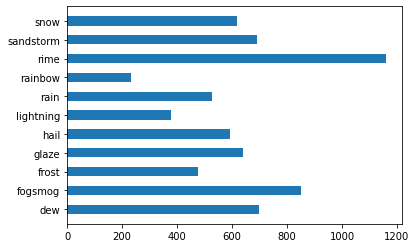

In [6]:
class_bar = np.array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow'])
count_class = count_class_df["count"]

plt.barh(class_bar,count_class,height = 0.5)
plt.show()

### 1.3 Data Split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
 
# for testing purpose
train_df = pd.DataFrame(data={"class": y_train})

x_train1, x_validate1, y_train1, y_validate1 = train_test_split(x_train, y_train, test_size=0.1764)

y_train1_categorical = tf.keras.utils.to_categorical(y_train1, num_classes=class_size)
y_validate1_categorical = tf.keras.utils.to_categorical(y_validate1, num_classes=class_size)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=class_size)

y_categorical = tf.keras.utils.to_categorical(y, num_classes=class_size)

In [8]:
print(f"Train size : {len(y_train1)}")
print(f"Validation size : {len(y_validate1)}")
print(f"Test size : {len(y_test)}")

Train size : 4802
Validation size : 1029
Test size : 1029


### Example


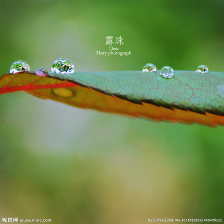

In [9]:
fig = px.imshow(x_train[3])
fig.add_annotation(
    x=0.51,
    y=-0.1,
    text="Image = fogsmog",
    xref="paper",
    yref="paper",
    showarrow=False,
    font_size=20, font_color='Black')
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

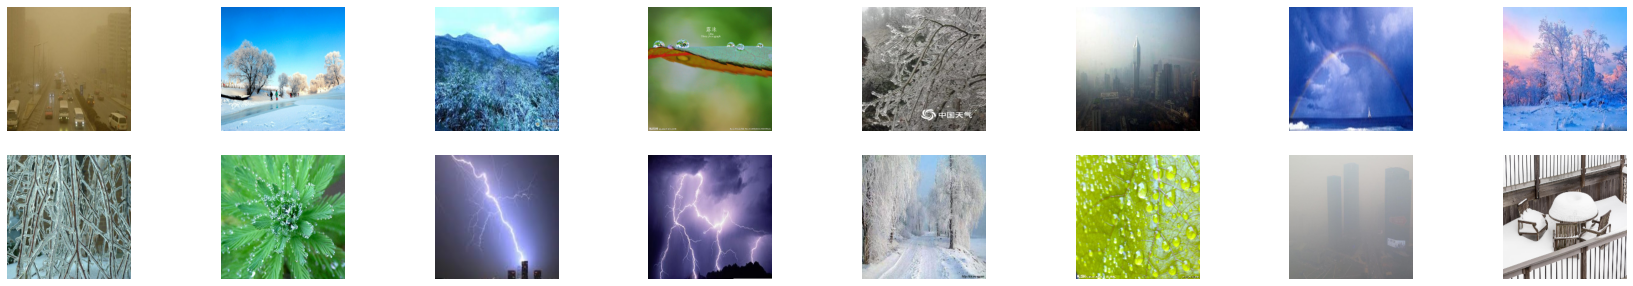

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(30, 5))

img_idx = 0
for i in range(2):
    for j in range(8):
        ax[i, j].imshow(x_train[img_idx])
        ax[i, j].axis('off')
        img_idx += 1

## 2. Create Model

### 2.1 ImageDataGenerator

In [11]:
#Create DataGenerator Object
datagen = ImageDataGenerator( rescale=1./255,
                            rotation_range=30, 
                            zoom_range=0.5,
                            width_shift_range=0.2, 
                            height_shift_range=0.2,
                            shear_range=0.15, 
                            horizontal_flip=True,
                            fill_mode="nearest"
                            )

In [12]:
# Create Train Image generator
train_generator =  datagen.flow(x_train1,
                                y_train1_categorical,
                                seed=10,
                                batch_size=32,
                                shuffle=True)

In [13]:

partial_train_generator =  datagen.flow(x_train1[:1000],
                                y_train1_categorical[:1000],
                                seed=10,
                                batch_size=32,
                                shuffle=True)

In [14]:
# # Create Validation Image generator
val_generator = datagen.flow(x_validate1,
                             y_validate1_categorical,
                            batch_size=32,
                            seed=10,
                            shuffle=True)

In [15]:

partial_val_generator = datagen.flow(x_validate1[:800],
                             y_validate1_categorical[:800],
                            batch_size=32,
                            seed=10,
                            shuffle=True)

In [16]:
all_generator = datagen.flow(x, y_categorical, batch_size=32, seed=10, shuffle=True)

### Example

(32, 224, 224, 3)


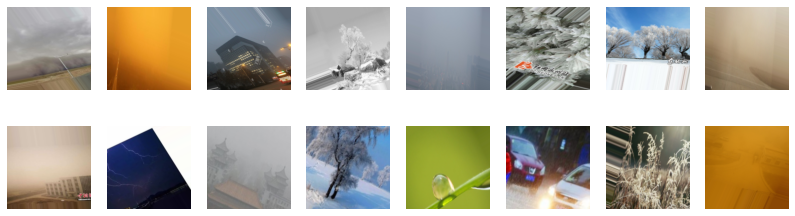

In [17]:
batch = train_generator.next()
img_train = (batch[0]*255).astype(np.uint8)
print(batch[0].shape)

n_row = train_generator.batch_size // 8

fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(14, 4))

img_idx = 0
for i in range(2):
    for j in range(8):
        ax[i, j].imshow(batch[0][img_idx])
        ax[i, j].axis('off')
        img_idx += 1

(-0.5, 223.5, 223.5, -0.5)

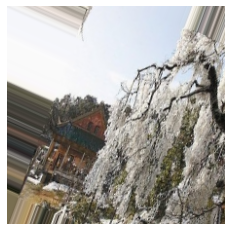

In [36]:
batch = train_generator.next()
img_train = (batch[0]*255).astype(np.uint8)

plt.imshow(batch[0][0])
plt.axis('off')

### 2.2 Model Setting

In [37]:
def build_model(hp):
  # Load base model
  pooling = hp.Choice("pooling", ["avg", "max"])
  base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", pooling=pooling)
  
  layer_freeze = hp.Int("layer_freeze", min_value=5, max_value=300, step=32)
  # Assign Trainable layers and freeze layer
  #base_model.trainable = False
  for layer in base_model.layers[:layer_freeze]:
      layer.trainable=False
        
  for layer in base_model.layers[layer_freeze:]:
      layer.trainable=True

  model = Sequential()
  model.add(base_model)
  
  units = hp.Int("units", min_value=128, max_value=1024, step=32)
  activation = hp.Choice("activation", ["relu", "sigmoid", "tanh"])
  model.add(Dense(units, activation=activation))

  if hp.Boolean("dropout"):
    model.add(Dropout(0.5))

  model.add(Dense(class_size, activation="softmax"))


  optimizer = hp.Choice("optimizer", ["adam", "sgd", "rmsprop", "adagrad"])
  # Create Optimizer

  loss = hp.Choice("loss", ["categorical_crossentropy", "kullback_leibler_divergence"])
  model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

  return model

## 3. Hyperparameter Tuning

In [38]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_acc",
    max_trials=40,
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/WeatherRecog",
    project_name="hyperparametertuning",
)

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/WeatherRecog/hyperparametertuning/oracle.json
87924736/87910968 [==============================] - 1s 0us/step
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/WeatherRecog/hyperparametertuning/tuner0.json


In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
pooling (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
layer_freeze (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 300, 'step': 32, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop', 'adagrad'], 'ordered': False}
loss (Choice)
{'default': 'categorical_crossentropy', 'conditions': [], 'values': ['categorical_crossentropy', 'kullback_leibler_divergence'], 'ordered': False}


### 3.1 Search

In [31]:
EPOCHS = 20

tuner.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

Trial 40 Complete [00h 31m 33s]
val_acc: 0.9076773524284363

Best val_acc So Far: 0.918367326259613
Total elapsed time: 05h 16m 55s
INFO:tensorflow:Oracle triggered exit


### 3.2 Best Model

In [40]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 224, 224, 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 320)               655680    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                3531      
                                                                 
Total params: 22,461,995
Trainable params: 21,635,259
Non-trainable params: 826,736
_________________________________________________________________


In [41]:
tuner.results_summary(1)

Results summary
Results in /content/drive/MyDrive/WeatherRecog/hyperparametertuning
Showing 1 best trials
Trial summary
Hyperparameters:
pooling: avg
layer_freeze: 69
units: 320
activation: relu
dropout: True
optimizer: sgd
loss: kullback_leibler_divergence
Score: 0.918367326259613


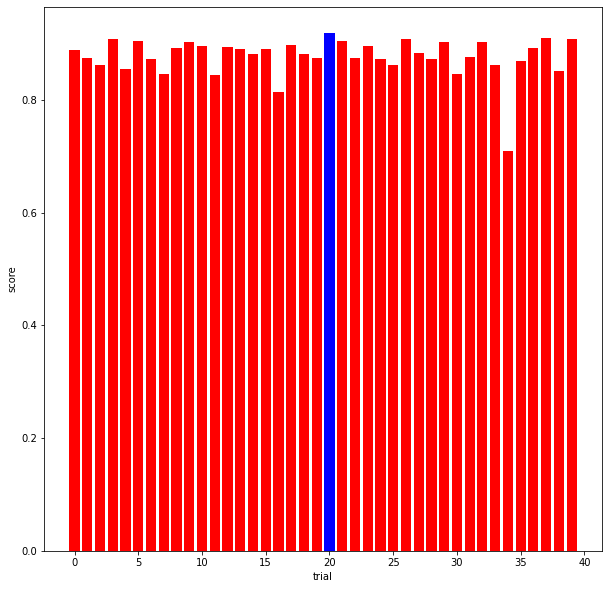

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))


best_trial = tuner.oracle.get_best_trials(1)[0]
best_score = best_trial.score

worst_trial = tuner.oracle.get_best_trials(40)[-1]
worst_score = worst_trial.score

for idx, trial in tuner.oracle.trials.items():
  color = "red"
  if trial.score == best_score:
    color = "blue"
  plt.bar(int(idx), trial.score, color=color)
  plt.ylabel("score")
  plt.xlabel("trial")
plt.show()

In [123]:
print(f"Best Trial Id: {best_trial.trial_id}")

Best Trial Id: 20


### 3.3 Best Model Performance

In [49]:
# Initial test generator
test_datagen= ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(x_test,
                                    y_test_categorical,
                                    shuffle=False, seed=42,
                                    batch_size=1)

In [22]:
#predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred = best_model.predict_generator(test_generator,verbose=True)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



1029/1029 [==============================] - 20s 10ms/step


In [23]:
#Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(pred)
df_class = df_pred.idxmax(axis=1)
df_class

0       9
1       1
2       2
3       9
4       1
       ..
1024    2
1025    4
1026    9
1027    8
1028    8
Length: 1029, dtype: int64

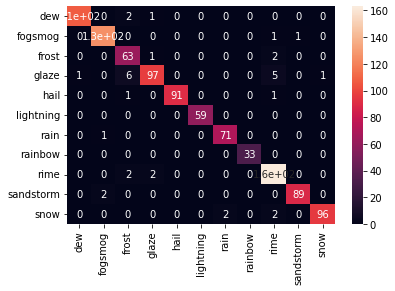

In [24]:
class_names = ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')
class_dict = dict(enumerate(class_names))

# Calculate confusion matrix, classification report between y_true and df_class
con_mat = confusion_matrix(y_test, df_class)
con_mat_df = pd.DataFrame(con_mat)
con_mat_df.rename(index=class_dict, columns=class_dict, inplace=True)
sns.heatmap(con_mat_df, annot=True)
plt.show()

In [25]:
print(classification_report(y_test, df_class, target_names=class_names))

              precision    recall  f1-score   support

         dew       0.99      0.97      0.98       110
     fogsmog       0.98      0.98      0.98       128
       frost       0.85      0.95      0.90        66
       glaze       0.96      0.88      0.92       110
        hail       1.00      0.98      0.99        93
   lightning       1.00      1.00      1.00        59
        rain       0.97      0.99      0.98        72
     rainbow       1.00      1.00      1.00        33
        rime       0.94      0.98      0.96       167
   sandstorm       0.99      0.98      0.98        91
        snow       0.99      0.96      0.97       100

    accuracy                           0.97      1029
   macro avg       0.97      0.97      0.97      1029
weighted avg       0.97      0.97      0.97      1029



### 3.4 Worst Model

In [46]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=40)
worst_model = models[-1]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
worst_model.build(input_shape=(None, 224, 224, 3))
worst_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 992)               2032608   
                                                                 
 dense_1 (Dense)             (None, 11)                10923     
                                                                 
Total params: 23,846,315
Trainable params: 23,801,771
Non-trainable params: 44,544
_________________________________________________________________


In [47]:
worst_trial.summary()

Trial summary
Hyperparameters:
pooling: max
layer_freeze: 5
units: 992
activation: tanh
dropout: False
optimizer: adam
loss: kullback_leibler_divergence
Score: 0.7084547877311707


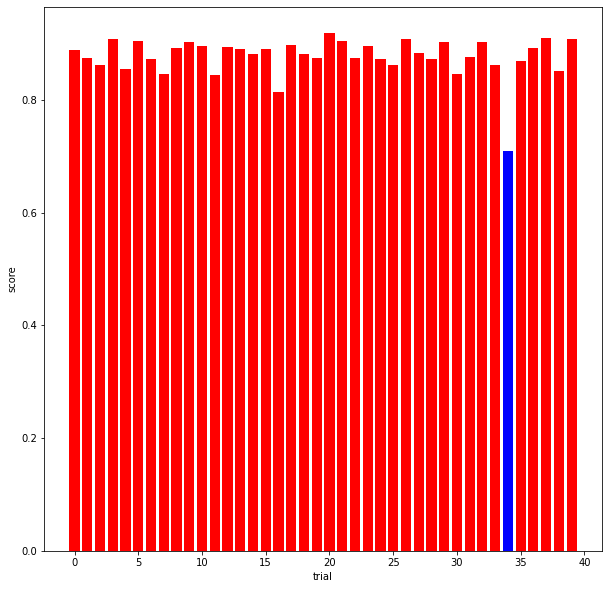

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

worst_trial = tuner.oracle.get_best_trials(40)[-1]
worst_score = worst_trial.score

for idx, trial in tuner.oracle.trials.items():
  color = "red"
  if trial.score == worst_score:
    color = "blue"
  plt.bar(int(idx), trial.score, color=color)
  plt.ylabel("score")
  plt.xlabel("trial")
plt.show()

### 3.5 Worst Model Performance

In [50]:
#predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
worst_pred = worst_model.predict_generator(test_generator,verbose=True)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



1029/1029 [==============================] - 21s 10ms/step


In [51]:
#Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(worst_pred)
worst_df_class = df_pred.idxmax(axis=1)
worst_df_class

0        2
1        1
2        1
3        1
4       10
        ..
1024     3
1025     0
1026    10
1027     6
1028     1
Length: 1029, dtype: int64

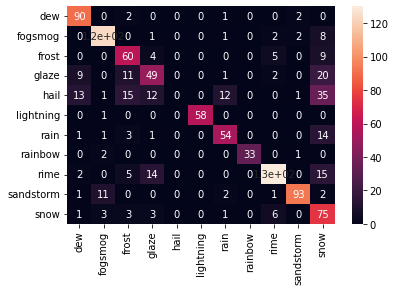

In [56]:
class_names = ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')
class_dict = dict(enumerate(class_names))

# Calculate confusion matrix, classification report between y_true and df_class
con_mat = confusion_matrix(y_test, worst_df_class)
con_mat_df = pd.DataFrame(con_mat)
con_mat_df.rename(index=class_dict, columns=class_dict, inplace=True)
sns.heatmap(con_mat_df, annot=True)
plt.show()

In [53]:
print(classification_report(y_test, worst_df_class, target_names=class_names))

              precision    recall  f1-score   support

         dew       0.77      0.95      0.85        95
     fogsmog       0.87      0.90      0.88       138
       frost       0.61      0.77      0.68        78
       glaze       0.58      0.53      0.56        92
        hail       0.00      0.00      0.00        89
   lightning       1.00      0.98      0.99        59
        rain       0.75      0.73      0.74        74
     rainbow       1.00      0.92      0.96        36
        rime       0.89      0.78      0.83       166
   sandstorm       0.94      0.85      0.89       110
        snow       0.42      0.82      0.56        92

    accuracy                           0.74      1029
   macro avg       0.71      0.75      0.72      1029
weighted avg       0.71      0.74      0.72      1029



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## 4. Train Model use Best HyperParam and Train with Train, Validate, Test

In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(1)
# Build the model with the best hp.
model = build_model(best_hps[0])

history = model.fit(train_generator, validation_data=val_generator, epochs=20)

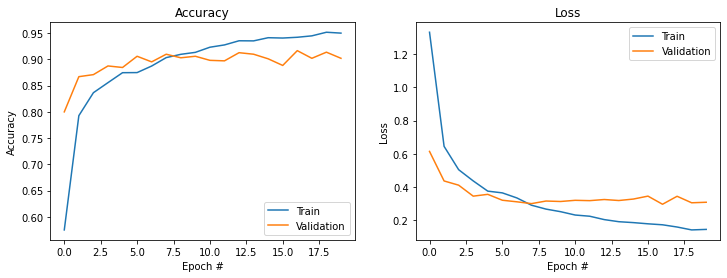

In [36]:
# Performance Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# View Accuracy (Training, Validation)
ax[0].plot(history.history["acc"], label="Train_acc")
ax[0].plot(history.history["val_acc"], label="Validate_acc")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Epoch #")
ax[0].set_ylabel("Accuracy")
ax[0].legend(["Train", "Validation"], loc="best")

# View Loss (Training, Validation)
ax[1].plot(history.history['loss'], label="Train_loss")
ax[1].plot(history.history['val_loss'], label="Validate_loss")
ax[1].set_title("Loss")
ax[1].set_xlabel("Epoch #")
ax[1].set_ylabel("Loss")
ax[1].legend(["Train", "Validation"], loc="best")

plt.show()

In [37]:
#predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred = model.predict_generator(test_generator,verbose=True)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



1029/1029 [==============================] - 12s 11ms/step


In [38]:
#Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(pred)
df_class = df_pred.idxmax(axis=1)
df_class

0       9
1       1
2       2
3       9
4       1
       ..
1024    2
1025    4
1026    9
1027    8
1028    8
Length: 1029, dtype: int64

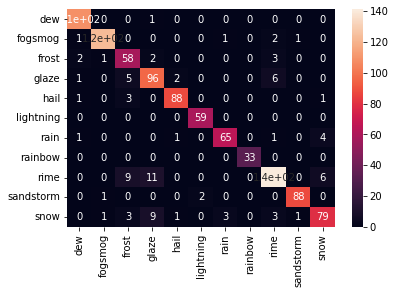

In [39]:
class_names = ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')
class_dict = dict(enumerate(class_names))

# Calculate confusion matrix, classification report between y_true and df_class
con_mat = confusion_matrix(y_test, df_class)
con_mat_df = pd.DataFrame(con_mat)
con_mat_df.rename(index=class_dict, columns=class_dict, inplace=True)
sns.heatmap(con_mat_df, annot=True)
plt.show()

In [40]:
print(classification_report(y_test, df_class, target_names=class_names))

              precision    recall  f1-score   support

         dew       0.95      0.99      0.97       110
     fogsmog       0.98      0.96      0.97       128
       frost       0.74      0.88      0.81        66
       glaze       0.81      0.87      0.84       110
        hail       0.96      0.95      0.95        93
   lightning       0.97      1.00      0.98        59
        rain       0.94      0.90      0.92        72
     rainbow       1.00      1.00      1.00        33
        rime       0.90      0.84      0.87       167
   sandstorm       0.98      0.97      0.97        91
        snow       0.88      0.79      0.83       100

    accuracy                           0.91      1029
   macro avg       0.92      0.92      0.92      1029
weighted avg       0.92      0.91      0.91      1029



## Save Model

In [26]:
tfjs.converters.save_keras_model(best_model, "/content/drive/MyDrive/weather_model01")